# Комп’ютерний практикум No1

### **Мета роботи:** навчитися виконувати статистичну обробку при значних вибірках значень експериментальних даних.

In [3]:
# List all required packages
library(tidyverse)
library(patchwork)
library(ggthemes)
library(ggpmisc)
library(writexl)
library(ggsci)
library("gridExtra")
options(repr.plot.width=20, repr.plot.height=10)
options(warn=-1)
options(digits = 4)

In [4]:
# Create dataframes for example and real datasets

# Example data
df <- data.frame(ph = c(9.8,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.0),
                 n = c(1,12,24,36,23,13,4,1,1))
# Real data
df1 <- data.frame(ph = c(10.3,10.1,10.2,10.4,10.5,10.6,10.8,10.9),
                 n = c(9,1,3,22,38,23,2,1))

### Впорядкування даних *(Data tidying)*

In [5]:
# Set data to example datasets
data <- df1
data_tidy <- as.data.frame(lapply(data,rep,data$n))

### Розрахунки (Calculations)

#### За необхідності відфільтровую значення з високою похибкою
#### *Filter the the measurments with error, redo the calculations!*

In [6]:
# Filter data with high error: abs(d) >= 3S
data_tidy <- data_tidy |> 
  filter(ph != 10.1 & ph != 10.9) 

In [7]:
# Calculate avg, sd, var and 3sd
ph_avg = mean(data_tidy$ph)
ph_sd = sd(data_tidy$ph)
ph_var = ph_sd**2
ph_3sd = ph_sd * 3

print(c(ph_avg, ph_sd, ph_var, ph_3sd))

[1] 10.4794  0.1127  0.0127  0.3380


In [8]:
# Working with data, check if pH fits in |d|< 3sd 
data_tidy_err <- data_tidy |> 
  group_by(ph) |> 
  summarise(
    n = n()
  ) |> 
  mutate(
    ph_d = abs(ph_avg - ph),
    err = if_else(ph_d > ph_3sd, "Error","Ok")
  )
data_tidy_err |>
  filter(err == "Error")
#> A tibble: 1 × 4
# ph	n	ph_d	err
# <dbl>	<int>	<dbl>	<chr>
# 9.8	1	0.4834783	Error <----- FILTER THIS VALUE BEFORE CALCULATIONS

ph,n,ph_d,err
<dbl>,<int>,<dbl>,<chr>


In [9]:
# Data calculation
data_ok <- data_tidy_err |> 
  mutate(
    p = n / sum(n),
    F_x = cumsum(p),
    phi_x = 1 / (ph_sd * sqrt(2 * pi)) * exp(-(ph - ph_avg)^2 / (2 * ph_sd^2)), 
    ph_pnorm = pnorm(ph, mean = ph_avg, sd = ph_sd),
    ph_dnorm = dnorm(ph, mean = ph_avg, sd = ph_sd),
  )
tibble(data_ok)


ph,n,ph_d,err,p,F_x,phi_x,ph_pnorm,ph_dnorm
<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10.2,3,0.27938,Ok,0.03093,0.03093,0.16369,0.006577,0.16369
10.3,9,0.17938,Ok,0.09278,0.12371,0.99703,0.055688,0.99703
10.4,22,0.07938,Ok,0.22680,0.35052,2.76251,0.240554,2.76251
10.5,38,0.02062,Ok,0.39175,0.74227,3.48189,0.572598,3.48189
10.6,23,0.12062,Ok,0.23711,0.97938,1.99636,0.857805,1.99636
10.8,2,0.32062,Ok,0.02062,1.00000,0.06178,0.997783,0.06178


### Розрахунки для знаходження довірчого інтервалу та остаточного результату

In [12]:

# Get the sum of all measurments
sum_n = sum(data_ok$n)

# Set the Student coeffient p = 95%,

f = (sum_n - 1)
tpf = 1.981
s_x = ph_sd / sqrt(sum_n)

delta_x = tpf * s_x

print(paste0("pH = ",round(ph_avg,2),"±",round(delta_x,2)))

[1] "pH = 10.48±0.02"


## Побудова графіків *(Plotting the graphs)*

In [13]:
p1 <- data_ok |> 
  ggplot(aes(x = ph, y = F_x)) +
  geom_point(color = "darkblue") + 
  geom_smooth(se = FALSE, span = 0.7, color = "darkblue") +
  xlab("Рис. 2. Інтегральна крива розподілу значень pH") +
  ylab("F(pH)") + 
  theme_clean()

p2 <- data_ok |> 
  ggplot(aes(x = ph, y = phi_x)) +
  geom_point(color = "darkblue") + 
  geom_smooth(se = FALSE, span = 0.7, color = "darkblue") +
  xlab("Рис. 3. Диференційна крива розподілу значень pH") +
  ylab("φ(pH)") + 
  theme_clean()

p3 <- data_ok |> 
  ggplot(aes(x = ph, y = ph_pnorm)) +
  geom_point(color = "darkblue") + 
  geom_smooth(se = FALSE, span = 0.7, color = "darkblue") +
  xlab("Рис. 4. Інтегральна крива розподілу значень pH") +
  ylab("F(pH)") + 
  theme_clean()

p4 <- data_ok |> 
  ggplot(aes(x = ph, y = ph_dnorm)) +
  geom_point(color = "darkblue") + 
  geom_smooth(se = FALSE, color = "darkblue", span = 0.7) +
  xlab("Рис. 5. Диференційна крива розподілу значень pH") +
  ylab("φ(pH)") + 
  theme_clean()

p5 <- data_ok |> 
  ggplot(aes(x = ph, y = p)) +
  geom_bar(stat = "identity", fill = "darkred") + 
  xlab("Рис. 1. Гістограма розподілу ймовірностей значень pH") +
  ylab("p") + 
  theme_clean()

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


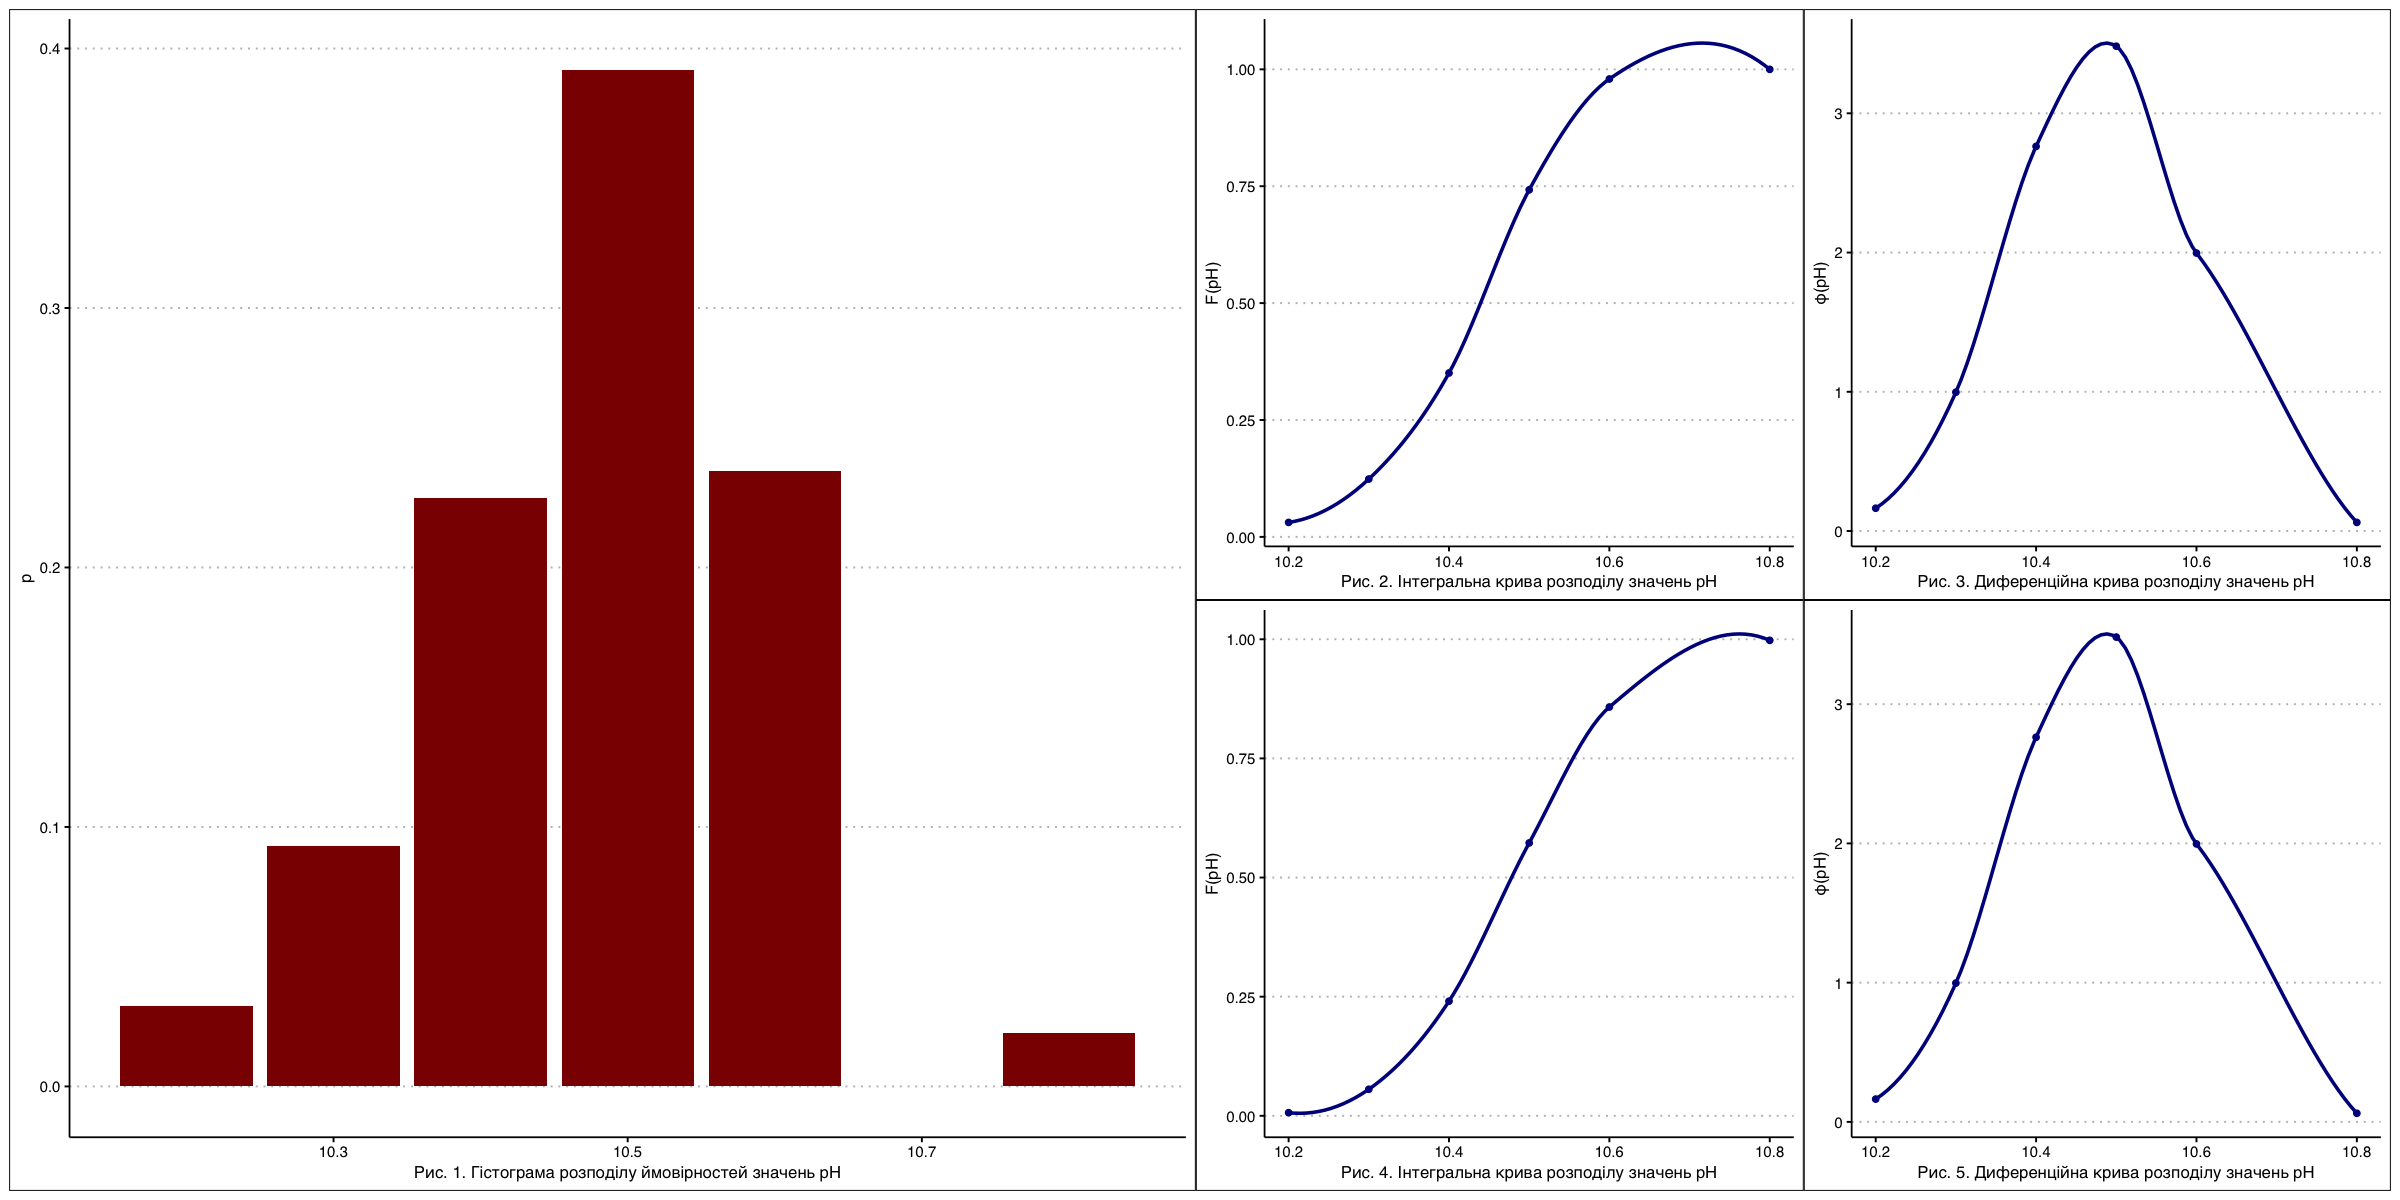

In [14]:
# Render the plots
suppressMessages(p5 | ((p1 + p2) / (p3 + p4)))

## Остаточний результат *(Final result)*

## ***pH = 10.48±0.02***